# How to simulate a supernova explosion in your lightcurve.

The K2 mission observed over 40,000 galaxies in anticipation of catching a glimpse at the earliest moments in the rise of supernovae.  Supernovae are usually discovered from daily-weekly cadence ground-based imaging survey telescopes such as [ASASSN](https://asas-sn.osu.edu/), [ROTSE](http://www.rotse.net/), [ATLAS](https://fallingstar.com/exploding_stars.php),  [Pan-STARRS](https://panstarrs.stsci.edu/), [PTF](https://www.ptf.caltech.edu/iptf), or [ZTF](https://www.ztf.caltech.edu/).  Typically a ground-based survey will trigger a [TNS alert](https://wis-tns.weizmann.ac.il/) when a supernova is identified.  Once a K2-observed host-galaxy has been deemed to have hosted a transient, its [high-precision supernova lightcurve can be extracted with lightkurve](http://lightkurve.keplerscience.org/tutorials/2.10-how-to-make-a-supernova-lightcurve.html).

What if you do not have ground-based measurements to verify that a supernova explosion went off?  What if you want to assess your *detection efficiency* to low-luminosity transients?  Perhaps most importantly, you may wish to assess how instrumental noise, or pre-processing/data-analysis methods degrade the known, injected signal.  Quantifying how your method degrades known signals may in turn help you refine and tune your algorithmic settings.

### caveat about light-curve level injection---which sources of noise are contained **

### say what the tool does, not what it doesn't do

### explicitly say what is additive or multiplicative.


`lightkurve` now includes experimental features to inject artificial signals into K2, Kepler, and TESS light curves. We currently support supernovae and planetary transits.  Rotational modulation and flares could be added in the future.

In [4]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [5]:
from lightkurve import KeplerTargetPixelFile

Let's download a K2 light curve of a galaxy. Currently, injection works on the light curve level, so we'll need to construct a light curve from the target pixel file.

In [6]:
tpf = KeplerTargetPixelFile.from_archive(249222500)   # A galaxy observed in K2
lc = tpf.to_lightcurve(aperture_mask='all')           # Returns a KeplerLightCurve

#Remove nans and outliers
lc = lc.remove_nans().remove_outliers()

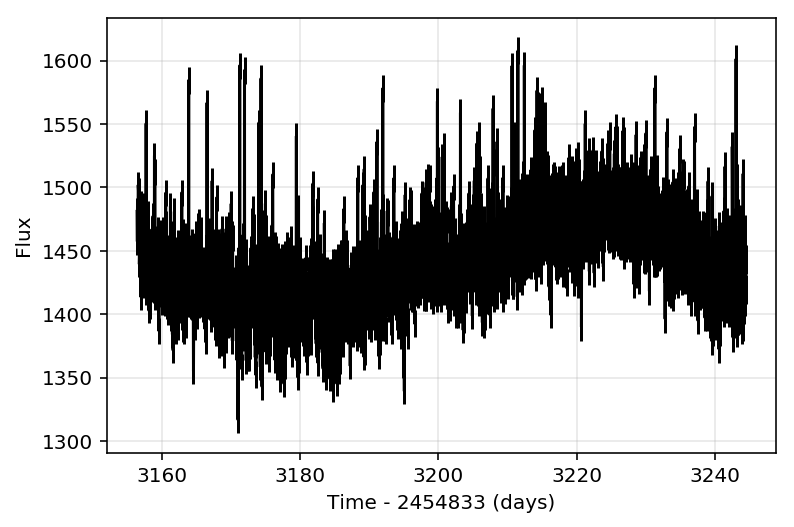

In [7]:
lc.plot(normalize=False);

The light curve of this galaxy is fairly smooth, with some variability from the spacecraft motion and thermal fluctuations.  Now let's create a supernova model with the new `SupernovaModel` class. You'll need to install [sncosmo](http://sncosmo.readthedocs.io/) for this class to work.

First we will import the injection module.

In [8]:
import lightkurve.injection as inj

You must specify the model source, bandpass, time zero point $t_0$, and redshift $z$ of the supernova.  The [Hsiao et al. 2007](http://adsabs.harvard.edu/abs/2007ApJ...663.1187H) model below takes an additional parameter, $a$ which represents the amplitude scaling factor for the overall supernova flux.
<br>
(Note: depending on the source, $t_0$ may specify either the time of outburst *or* the peak of the supernova.)
<br>

In [9]:
sn_model = inj.SupernovaModel(T0=3180, source='hsiao', bandpass='kepler', z=0.1, amplitude=3.0e-8)
sn_model

SupernovaModel({'sn_params': {'amplitude': 3e-08}, 'T0': 3180, 'source': 'hsiao', 'signaltype': 'Supernova', 'multiplicative': False, 'z': 0.1, 'bandpass': 'kepler'})

You can preview the light curve with the `.evaluate()` method, which computes the model function at each time point.

In [10]:
sn_flux = sn_model.evaluate(lc.time)

For *Kepler/K2*, units of the resultant supernova flux are $\rm \frac{e}{s}$-- the same as a lightcurve derived from calibrated target pixel files using `lightkurve`.  For now, other telescope bandpassess will return units of $\rm \frac{photons}{s \; cm^2}$, the `SNcosmo` default.  What does the supernova look like?

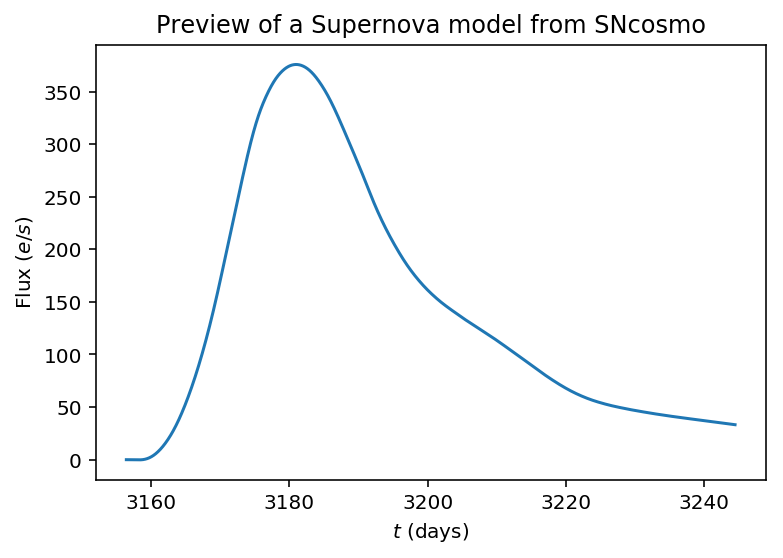

In [11]:
plt.plot(lc.time, sn_flux)
plt.title('Preview of a Supernova model from SNcosmo')
plt.ylabel('Flux $(e/s)$')
plt.xlabel('$t$ (days)');

We can inject this supernova model into our K2 light curve using the `.inject()` method.  We don't need to pre-compute the supernova model, simply pass in the model object, which will get evaluated at the same time points as the lightcurve object.

In [12]:
lc_with_supernova = lc.inject(sn_model)
lc_with_supernova

SyntheticLightCurve: Supernova Source

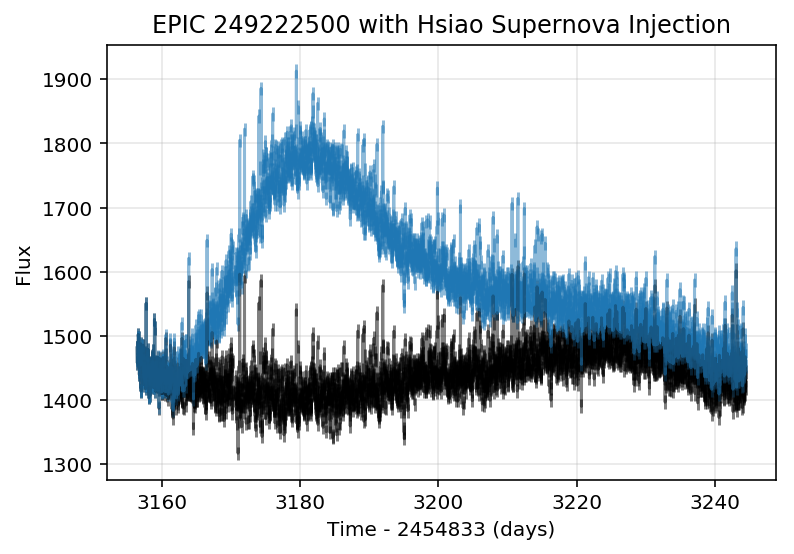

In [13]:
ax = lc.plot(normalize=False, alpha=0.5)
lc_with_supernova.plot(normalize=False, ax=ax, alpha=0.5)
plt.title('EPIC 249222500 with Hsiao Supernova Injection');

Success! We injected a supernova light curve into this galaxy!  

#### Note about noise sources in lightcurve-level injections
The supernova signal will not possess the same instrumental artifacts as a *real* K2 supernova.  For example, the "sawtooth" pattern will be absent, and thermal-induced PSF changes will be lost.  But *background* variation due to *e.g.* rolling band *will* be captured in the Synthetic Light Curve which has been added to a lightcurve already possessing additive background artiacts.

### Wide support for supernova models and random model parameter assignment

We automatically support any models that exist in `SNcosmo`.  You can specify the model source with the `source` keyword, and input the model parameters using `kwargs` to `SupernovaModel` in any order. Parameters can also be chosen randomly from a uniform distribution using `inj.UniformDistribution`, or a Gaussian distribution using `inj.GaussianDistribution`. For example, let's simulate a supernova with the **SALT2** model, which takes 5 parameters ($t_0$, $z$, $x_0$, $x_1$, and $c$), and choose $z$ randomly from a Gaussian distribution with mean 0.5 and sigma 0.2:

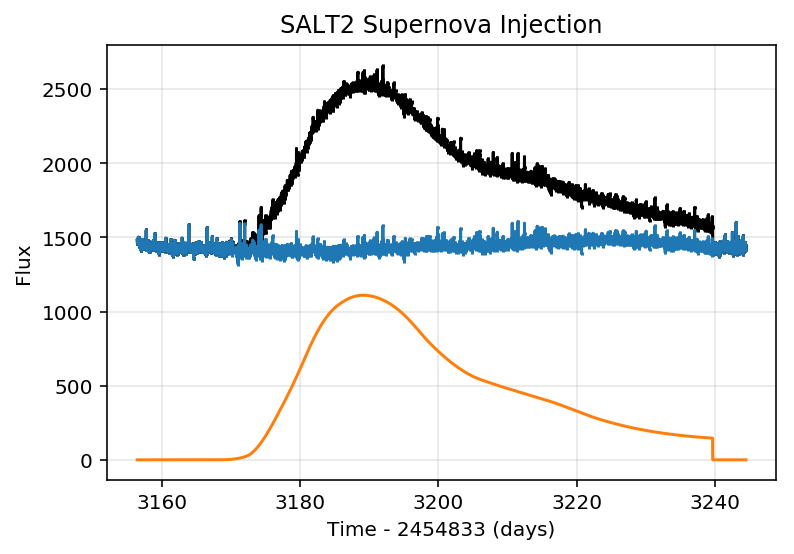

In [14]:
model = inj.SupernovaModel(T0=3189, source='salt2', bandpass='kepler', 
                           z=inj.UniformDistribution(0.01,0.02), x0=2.0e-3, x1=1.0e-2, c=-0.1)
lcinj = lc.inject(model)
ax = lcinj.plot(normalize=False)
lc.plot(normalize=False, ax=ax)
ax.plot(lc.time, model.evaluate(lc.time))
plt.title('SALT2 Supernova Injection');

Every time you create a new model, a new $z$ will be chosen from this Gaussian distribution, so you can quickly inject supernovae of many $z$ values.

## Recover known or unknown supernovae signals with `.recover()`

You can attempt to fit a signal (either artificial or real data) with the `.recover()` method.  

In [15]:
#params = lcinj.recover('Supernova')

In [18]:
params = inj.recover(lcinj.time, lcinj.flux, lcinj.flux_err, 'Supernova', source='hsiao')

In [19]:
fitted_model = inj.SupernovaModel(T0=params[0], source='hsiao', bandpass='kepler',
                                  z=params[1], amplitude=params[2])

In [20]:
bf_lc = fitted_model.evaluate(lcinj.time) + params[3]

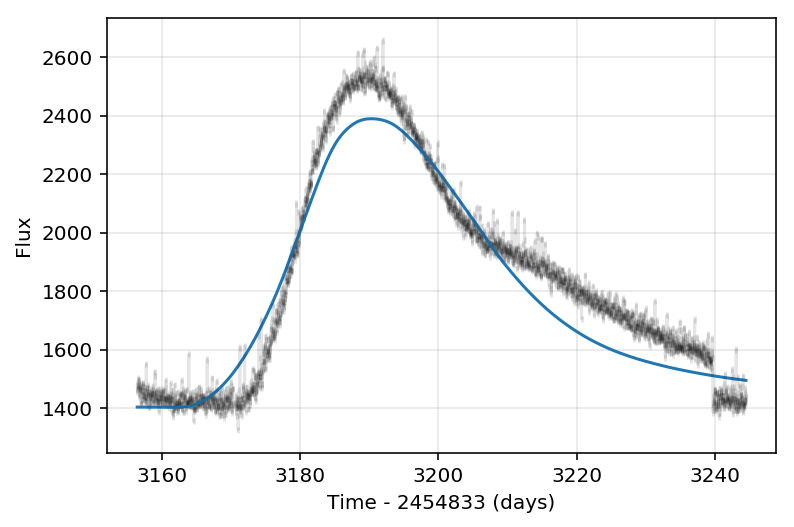

In [21]:
ax = lcinj.plot(normalize=False, alpha=0.1)
plt.plot(lc.time, bf_lc)